<a id='Table of Contents'></a><h1>Table of Contents</h1>

- <a href='#introduction'>Introduction</a> 
- <a href='#imports'>Import and install required libraries</a>  
- <a href='#set_fitting'>Setting of fitting</a>  
- <a href='#run_fit'>Running the fit</a>  
- <a href='#results'>Showing the results</a> 

(<a href='#Table of Contents'>Top</a>)<a id='introduction'></a><h2>Introduction</h2>

<div class="alert alert-block alert-info">
The objective of this notebook is to show how to use the <b>water_teixeira</b> model .
</div>

The data are two sets of water data measured at IN5 (ILL) using two different wavelengths.

**Reference:** J. Qvist, H. Schober and B. Halle, *J. Chem. Phys.* **134**, 144508 (2011)

(<a href='#Table of Contents'>Top</a>)<a id='imports'></a><h2> Import python modules for plotting, fitting... </h2>

In [1]:
# Imported required libraries
from __future__ import print_function
import sys
import os

import ipywidgets

# the following two lines are to remove the warning about too many figures open simultaneously
import matplotlib
matplotlib.rcParams.update({'figure.max_open_warning': 0})

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# install bumps (if not already installed)
import pkgutil
if not pkgutil.find_loader("bumps"):
    !{sys.executable} -m pip install bumps
    
# check version of bumps installed
# Information message if installed version not recent enough
import bumps

from distutils.version import StrictVersion
if StrictVersion(bumps.__version__) <= StrictVersion('0.7.6'):
    print("""The version of bumps installed is not recent 
    enough to run the examples. 
    Please update bumps. The minimum version required is 0.7.8""")

 (<a href='#Table of Contents'>Top</a>)<a id='set_fitting'></a><h2>Setting of fitting </h2>
<h3> load data, prepare data, create fitting model and set initial guesses </h3>


In [3]:
# install QENSmodels (if not already installed)

if not pkgutil.find_loader("QENSmodels"):
    !{sys.executable} -m pip install git+https://github.com/QENSlibrary/QENSmodels#egg=QENSmodels

In [4]:
import h5py
import QENSmodels
import numpy as np
from scipy.integrate import simps
from bumps.names import *
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty

path_to_data = './data/'

# Data
# Wavelength 5 Angstrom
f = h5py.File(path_to_data + 'H2O_293K_5A.hdf', 'r')
hw_5A = f['entry1']['data1']['X'][:]
q_5A = f['entry1']['data1']['Y'][:]
sqw_5A = np.transpose(f['entry1']['data1']['DATA'][:])
err_5A = np.transpose(f['entry1']['data1']['errors'][:])
f.close()

# Wavelength 8 Angstrom
f = h5py.File(path_to_data + 'H2O_293K_8A.hdf', 'r')
hw_8A = f['entry1']['data1']['X'][:]
q_8A = f['entry1']['data1']['Y'][:]
sqw_8A = np.transpose(f['entry1']['data1']['DATA'][:])
err_8A = np.transpose(f['entry1']['data1']['errors'][:])
f.close()

# Resolution
# Wavelength 5 Angstrom
f = h5py.File(path_to_data + 'V_273K_5A.hdf', 'r')
res_5A = np.transpose(f['entry1']['data1']['DATA'][:])
f.close()

# Wavelength 8 Angstrom
f = h5py.File(path_to_data + 'V_273K_8A.hdf', 'r')
res_8A = np.transpose(f['entry1']['data1']['DATA'][:])
f.close()

# Force resolution function to have unit area
# 5 Angstrom
for i in range(len(q_5A)):
    area = simps(res_5A[:,i], hw_5A)
    res_5A[:,i] /= area 
    
# 8 Angstrom
for i in range(len(q_8A)):
    area = simps(res_8A[:,i], hw_8A)
    res_8A[:,i] /= area
    
# Fit range -1 to +1 meV
idx_5A = np.where(np.logical_and(hw_5A > -1.0, hw_5A < 1.0))
idx_8A = np.where(np.logical_and(hw_8A > -1.0, hw_8A < 1.0))

def model_convol(x, q, scale=1, center=0, D=1, resTime=1, radius=1, DR=1, resolution=None):
    model = QENSmodels.sqwWaterTeixeira(x, q, scale, center, D, resTime, radius, DR)
    return np.convolve(model, resolution/resolution.sum(), mode='same')

# Fit
M = []

# First dataset: wavelength=5 Angstrom 
for i in range(len(q_5A)):

    x = hw_5A[idx_5A]
    data = sqw_5A[idx_5A, i]
    error = err_5A[idx_5A, i]
    resol = res_5A[idx_5A,i]
        
    # Select only valid data (error = -1 for Q, w points not accessible)
    valid = np.where(error > 0.0)
    x = x[valid[1]]
    data = data[valid]
    error = error[valid]
    resol = resol[valid]

    # Teixeira model        
    Mq = Curve(model_convol, x, data, error, q=q_5A[i],
               scale=10, center=0.0, D=0.13, resTime=0.1, radius=1.0, 
               DR=0.3, resolution=resol)
    
    # Fitted parameters    
    Mq.scale.range(0, 1e2)
    Mq.center.range(-0.1,0.1)
    Mq.D.range(0.05, 0.25)
    Mq.resTime.range(0,1)
    Mq.radius.range(0.9,1.1)
    Mq.DR.range(0,1)
    
    # Q-independent parameters
    if i == 0:
        QD = Mq.D
        QT = Mq.resTime
        QR = Mq.radius
        QDR = Mq.DR
    else:
        Mq.D = QD
        Mq.resTime = QT
        Mq.radius = QR
        Mq.DR = QDR
   
    M.append(Mq)
    
# Second dataset: wavelength=8 Angstrom
for i in range(len(q_8A)):

    x = hw_8A[idx_8A]
    data = sqw_8A[idx_8A, i]
    error = err_8A[idx_8A, i]
    resol = res_8A[idx_8A,i]
        
    # Select only valid data (error = -1 for Q, w points not accessible)
    valid = np.where(error > 0.0)
    x = x[valid[1]]
    data = data[valid]
    error = error[valid]
    resol = resol[valid]
    
    Mq = Curve(model_convol, x, data, error, q=q_8A[i],
               scale=10, center=0.0, D=0.13, resTime=0.1, radius=1.0, 
               DR=0.3, resolution=resol)

    # Fitted parameters    
    Mq.scale.range(0, 1e2)
    Mq.center.range(-0.1,0.1)
    Mq.D.range(0.05, 0.25)
    Mq.resTime.range(0,1)
    Mq.radius.range(0.9,1.1)
    Mq.DR.range(0,1)
    
    # Q-independent parameters set with 5A data
    Mq.D = QD
    Mq.resTime = QT
    Mq.radius = QR
    Mq.DR = QDR
       
    M.append(Mq) 
    
problem = FitProblem(M)

<h3> Choice of minimizer for bumps </h3>

In [5]:
w_choice_minimizer = ipywidgets.widgets.Dropdown(
    options={'Levenberg-Marquardt': "lm", 
             'Nelder-Mead Simplex': "amoeba", 
             'DREAM': "dream", 
             'Differential Evolution': "de", 
             'Quasi-Newton BFGS': "newton", 
             'Random Lines (experimental)': "rl", 
             'Particle Swarm (experimental)': "ps", 
             'Parallel Tempering (experimental)': "pt"},
    value="lm",
    description='Minimizer:',)

display(w_choice_minimizer)

Dropdown(description='Minimizer:', options={'Levenberg-Marquardt': 'lm', 'Nelder-Mead Simplex': 'amoeba', 'DRE…

<h3> Setting for running bumps </h3>

In [6]:
# CHOICE OF MINIMIZER
minimiser = w_choice_minimizer.value

# NUMBER OF STEPS WHEN RUNNING THE FIT
steps = 100

Initial chisq 5235.127(13)


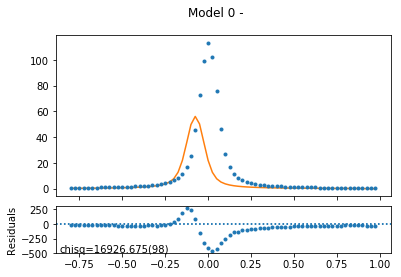

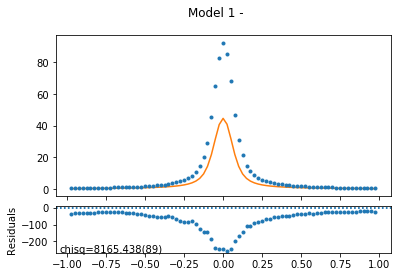

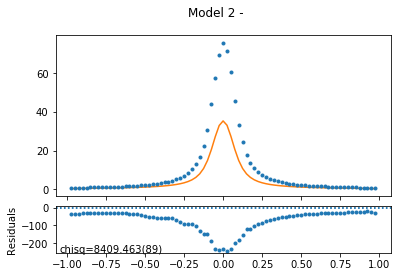

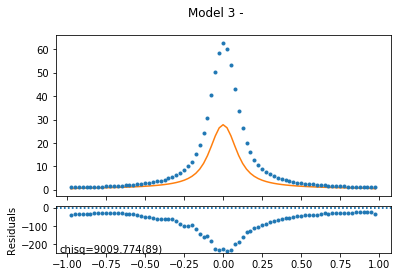

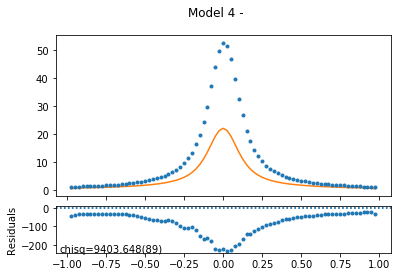

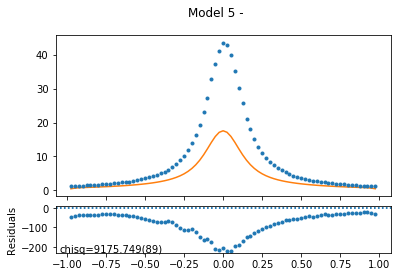

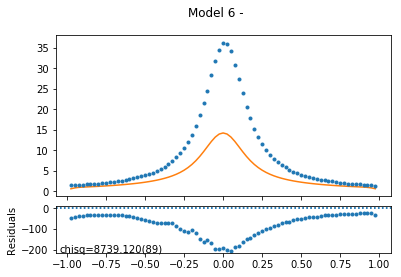

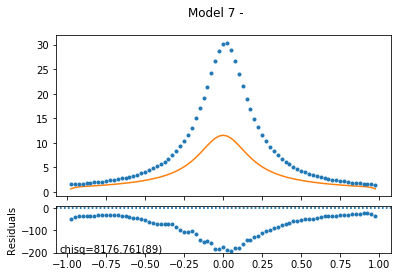

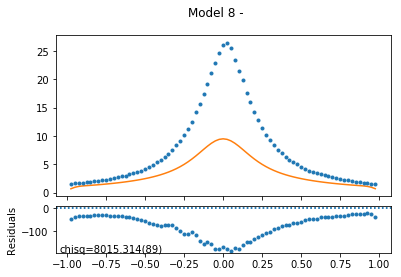

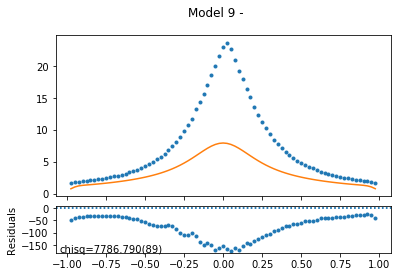

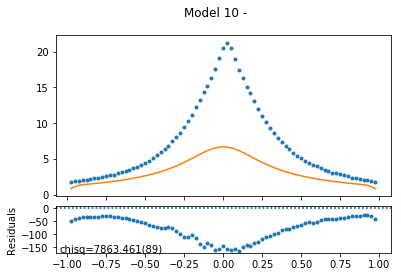

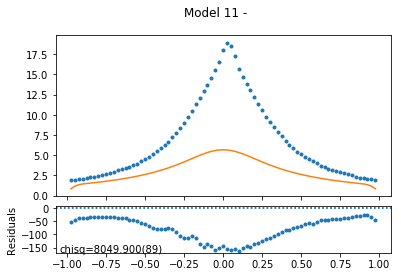

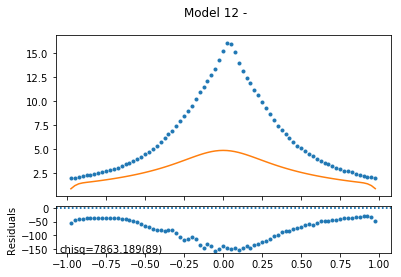

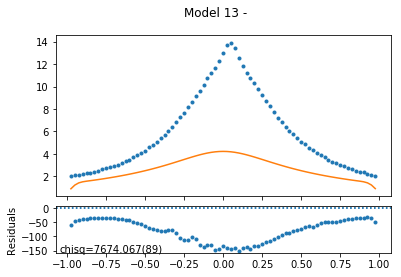

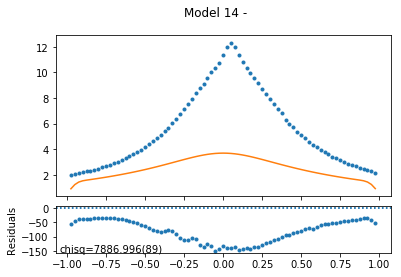

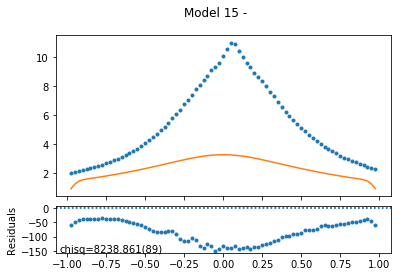

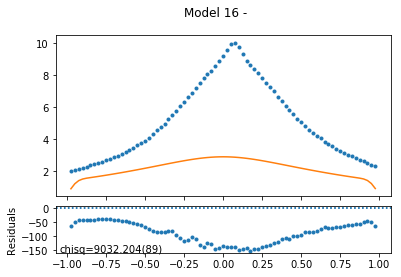

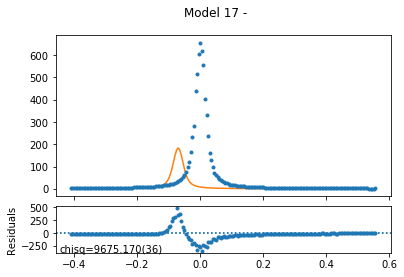

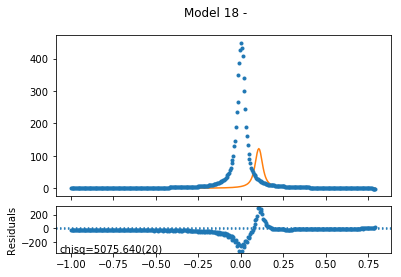

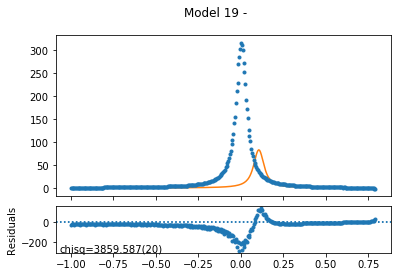

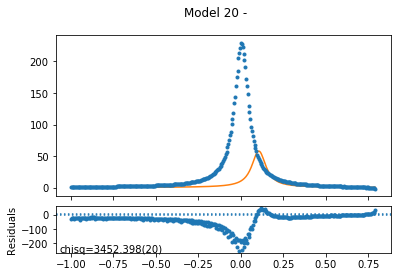

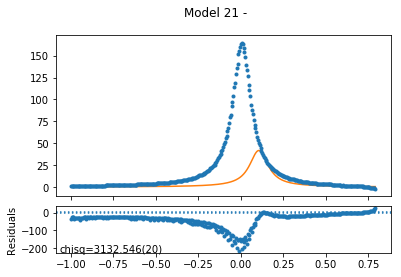

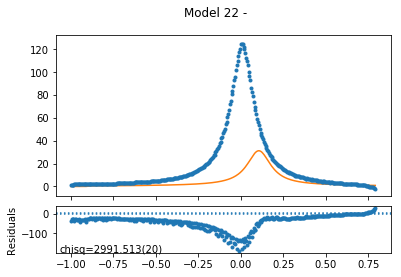

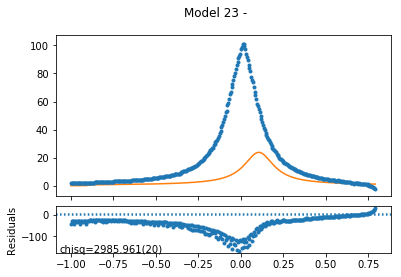

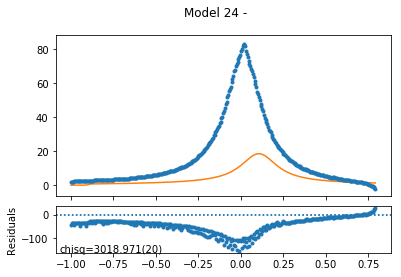

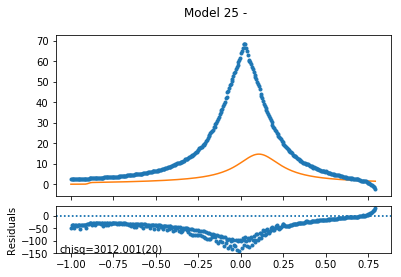

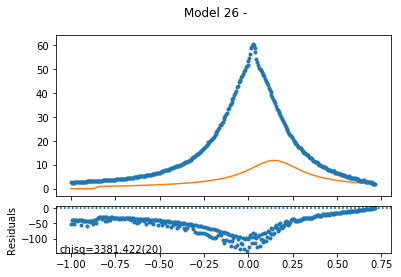

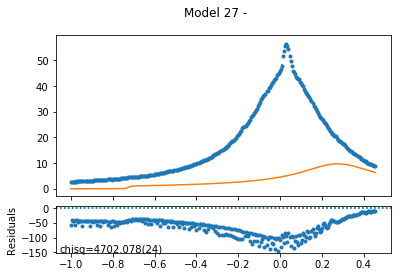

In [7]:
# Preview of the settings
print('Initial chisq', problem.chisq_str())
problem.plot()

(<a href='#Table of Contents'>Top</a>)<a id='run_fit'></a><h2>Running the fit</h2>

Run the fit using the *minimizer* defined above with a number of *steps* also specified above.

In [8]:
result = fit(problem, 
             method=w_choice_minimizer.value, 
             steps=steps, 
             verbose=True)

final chisq 4304.804(13)
=== Uncertainty est. from curvature: par    dx           dx/sqrt(chisq) ===
                                       D 0.12996(17)     0.1299640(25)  
                                      DR 0.1875(17)      0.187511(26)   
                                  center 0.003295(86)    0.0032952(13)  
                                  radius 0.9000(31)      0.900000(47)   
                                 resTime 0.4738(72)      0.47384(11)    
                                   scale 9.947(12)       9.94742(18)    
                                  center -0.00(10)e9     -0.0(15)e6     
                                   scale 10.873(13)      10.87320(21)   
                                  center -0.00(10)e9     -0.0(15)e6     
                                   scale 10.885(14)      10.88524(21)   
                                  center 0.07(12)e-3     66.6(18)e-6    
                                   scale 10.912(14)      10.91169(21)   
                       

(<a href='#Table of Contents'>Top</a>)<a id='results'></a><h2>Showing the results </h2>

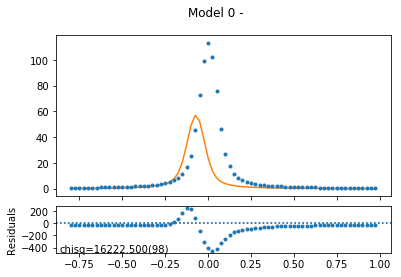

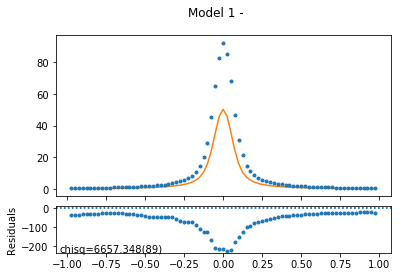

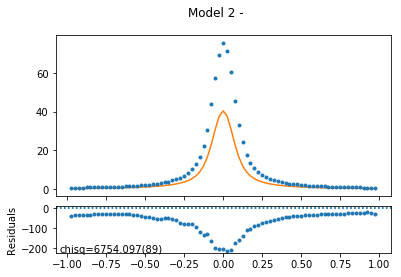

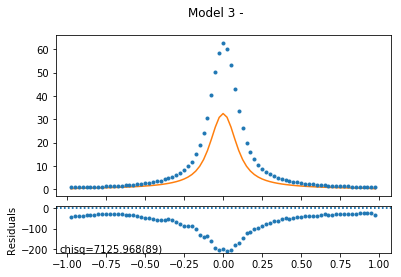

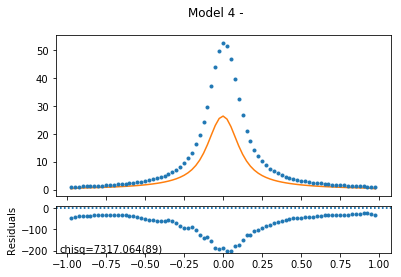

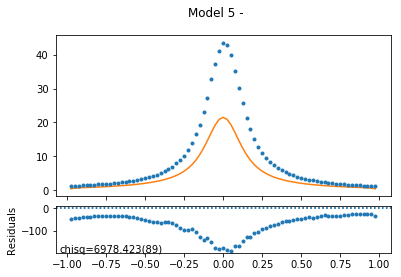

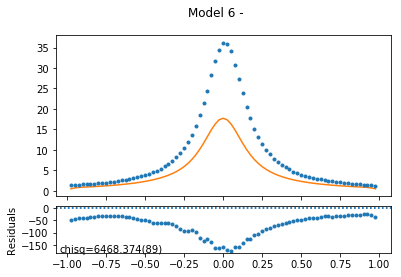

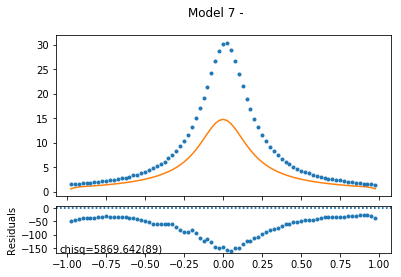

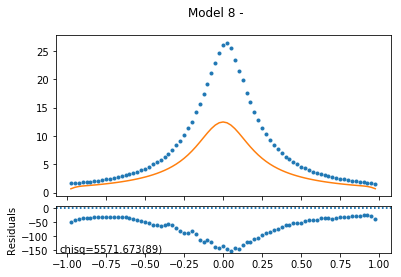

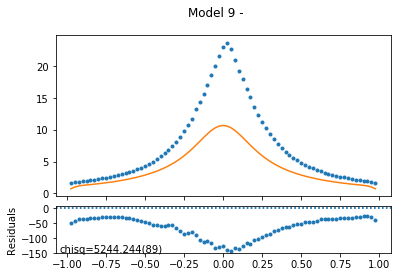

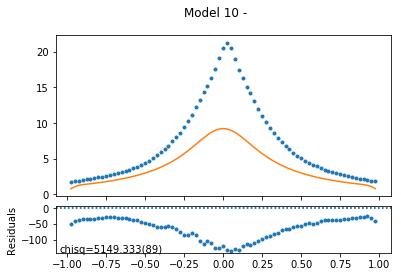

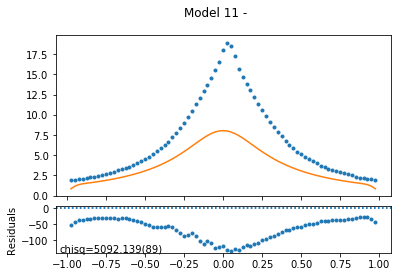

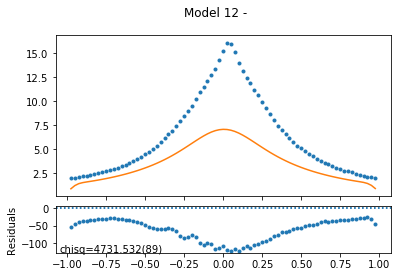

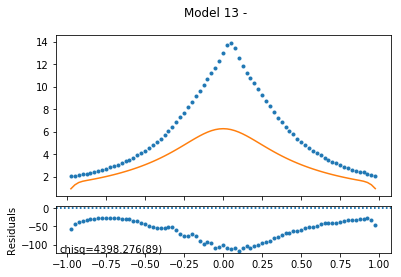

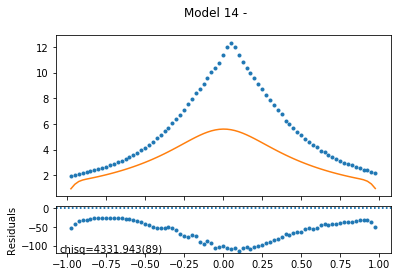

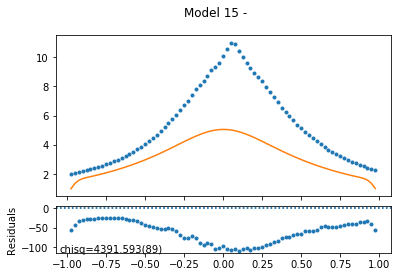

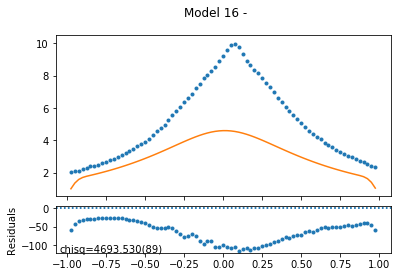

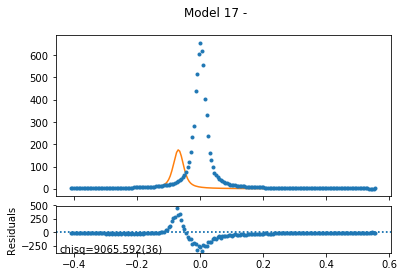

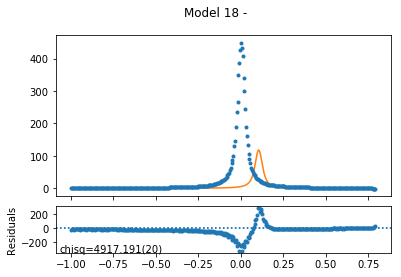

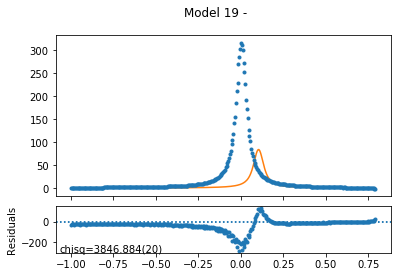

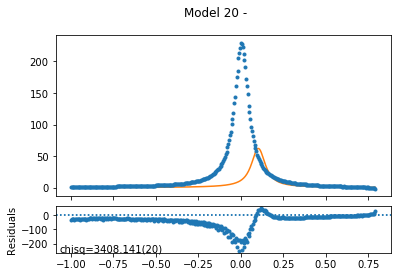

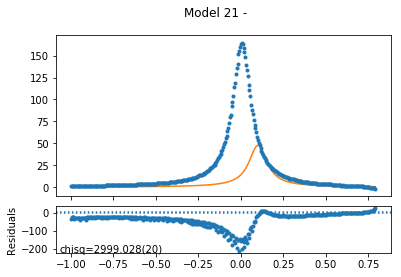

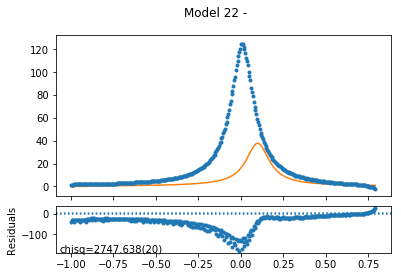

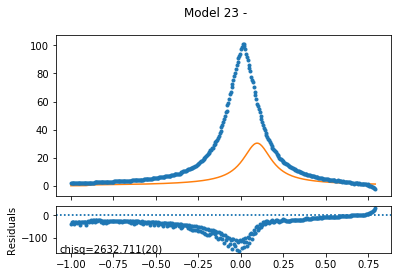

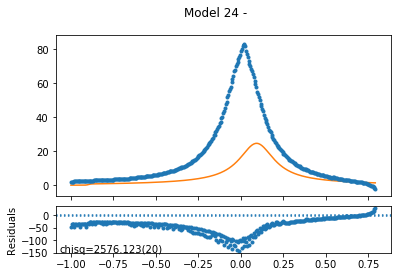

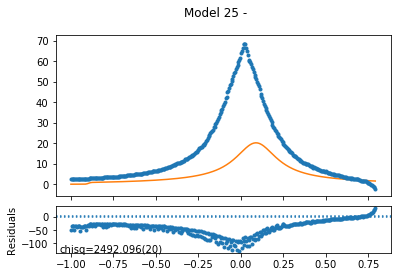

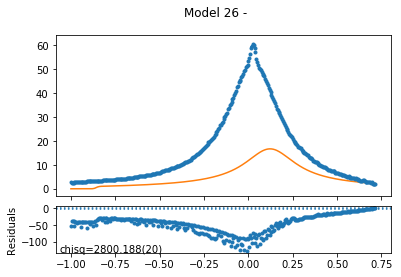

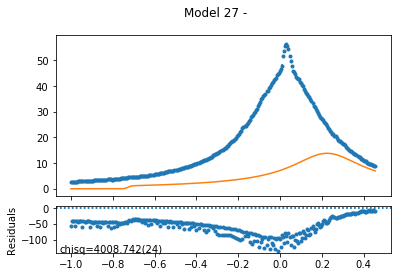

In [9]:
problem.plot()

In [10]:
# Print chi**2 and parameters' values after fit
print("final chisq", problem.chisq_str())
for k, v, dv in zip(problem.labels(), result.x, result.dx):
    print(k, ":", format_uncertainty(v, dv))

final chisq 4304.804(13)
D : 0.12996(17)
DR : 0.1875(17)
center : 0.003295(86)
radius : 0.9000(31)
resTime : 0.4738(72)
scale : 9.947(12)
center : -0.00(10)e9
scale : 10.873(13)
center : -0.00(10)e9
scale : 10.885(14)
center : 0.07(12)e-3
scale : 10.912(14)
center : -0.00181(21)
scale : 10.927(14)
center : 0.08(21)e-3
scale : 10.907(14)
center : 0.00(10)e9
scale : 10.872(14)
center : -0.75(36)e-3
scale : 10.825(14)
center : -0.30(37)e-3
scale : 10.797(14)
center : 0.19(34)e-3
scale : 10.777(15)
center : 0.21(61)e-3
scale : 10.775(15)
center : -0.63(57)e-3
scale : 10.772(15)
center : 0.00474(70)
scale : 10.747(15)
center : 0.00(10)e9
scale : 10.718(15)
center : 0.00334(86)
scale : 10.716(16)
center : 0.00169(91)
scale : 10.724(16)
center : 10.0(10)e-3
scale : 10.748(16)
center : 642(24)e-6
scale : 9.4337(94)
center : -769(37)e-6
scale : 9.491(11)
center : -0.001580(76)
scale : 9.819(15)
center : -0.00289(14)
scale : 10.286(20)
center : -0.00471(21)
scale : 10.761(24)
center : -0.00687(2